<a href="https://colab.research.google.com/github/VansYeh/TensorFlow/blob/master/mnist_on_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
sys.path.append(r'/content/drive/My Drive/Colab Notebooks/mnist_data/')

In [3]:
from load_mnist import load_mnist as mnist

#load mnist to (x_train, y_train), (x_test, y_test)
mnist_train=r'/content/drive/My Drive/Colab Notebooks/mnist_data/mnist_train.csv'
mnist_test=r'./sample_data/mnist_test.csv'


a = mnist(mnist_train, mnist_test)
(x_train, y_train), (x_test, y_test) = a.load_mnist(one_hot_label=True)

Reading csv file...
File /content/drive/My Drive/Colab Notebooks/mnist_data/mnist_train.csv load finish...
File ./sample_data/mnist_test.csv load finish...
transfor to np.ndarray START...
Done


#Check mnist data if it has been loaded

In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)


In [0]:
import tensorflow as tf

batch_size=100
learning_rate = 0.8
learning_rate_decay=0.999
max_step=10000

#initial train steps for record train times
training_step = tf.Variable(0, trainable=False)

## 準備訓練數據集

In [0]:
a.setBatchSize(batch_size)
x_validation, y_validation = a.get_next_batch()

## 定義得到的隱藏層和輸出層向前傳播的計算方式

In [0]:
def hidden_layer(x, w1,b1,w2,b2,layer_name):
    layer1 = tf.nn.relu(tf.matmul(x,w1)+b1)
    layer2 = tf.matmul(layer1,w2)+b2
    return layer2

## 定義引層 weight 和 bias

In [0]:
x = tf.placeholder(tf.float32, (None, 784), name='input')
y_ = tf.placeholder(tf.float32, (None, 10), name='answer')

w1 = tf.Variable(tf.truncated_normal((784,500), stddev=0.1))
b1 = tf.Variable(tf.constant(0.1,shape=[500]))
w2 = tf.Variable(tf.truncated_normal((500,10), stddev=0.1))
b2 = tf.Variable(tf.constant(0.1,shape=[10]))

## 定義 y 向前傳播的方式，可以透過 sess.run(y) 得到分類結果

In [0]:
y = hidden_layer(x, w1,b1,w2,b2,layer_name='y_query') 

## 初始化滑動平均類，用來取得 weight & bias 每個 batch 訓練的平均
## 其中設置 weight 和 bias 的衰減率 MAX: 0.99
## 最後用滑動平均的輸出預測 輸入，***可能*** 會表現更好

In [10]:
average_class = tf.train.ExponentialMovingAverage(0.99, training_step)

#定義一個更新變量滑動平均值得操作需要向滑動平均的類 apply() 函數提供 data list
#train_variables() 會返回所有 trainable 的 Variable(Graph.TRAINABLE_VARIABLES 中的數據)
avg_op = average_class.apply(tf.trainable_variables())

#用 1 個 batch data 計算 y，並得到滑動平均的輸出
avg_y = hidden_layer(x, average_class.average(w1),average_class.average(b1),average_class.average(w2),average_class.average(b2),layer_name='avg_y') 

W0705 07:21:21.712387 140680939014016 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/moving_averages.py:433: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


## 使用 sparse_softmax_cross_entropy_with_logits 為 交叉熵函數 計算 loss，可以針對單分類問題使用，像是手寫數字一般圖片裡面只有一個數字

> Measures the probability error in discrete classification tasks in which the classes are mutually exclusive (each entry is in exactly one class). For example, each CIFAR-10 image is labeled with one and only one label: an image can be a dog or a truck, but not both.


## 這邊還多加上了 正則化 L2 Function

> 正則化常用來降低 Noise 對模型的影響， 在總損失函數中：L(w)，通常搭配使用: 
> L(w) = J(w) + r * R(w)





In [11]:
cross_rentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y, labels=tf.argmax(y_,1))

regularizer = tf.contrib.layers.l2_regularizer(0.0001)
regularization = regularizer(w1)+regularizer(w2)
loss = tf.reduce_mean(cross_rentropy) + regularization

#指數衰減法 設置 learning rate
le_rate = tf.train.exponential_decay(learning_rate, training_step, x_train.shape[0]/batch_size, learning_rate_decay)

#使用梯度下降優化損失函數 L(w)
trainer = tf.train.GradientDescentOptimizer(le_rate).minimize(loss, global_step=training_step)

# tf.control_dependencies() 设计是用来控制计算流图的，给图中的某些计算指定顺序
with tf.control_dependencies([trainer, avg_op]):
    train_op = tf.no_op(name='train')

W0705 07:21:24.301092 140680939014016 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## 最後要印出正確率

In [0]:
crorent_predicition = tf.equal(tf.argmax(avg_y, 1), tf.argmax(y_, 1))

accuracy = tf.reduce_mean(tf.cast(crorent_predicition, tf.float32))

sess = tf.Session()

initializer = tf.global_variables_initializer()

sess.run(initializer)

In [0]:
###mv '/content/drive/My Drive/Colab Notebooks/mnist_data/load_mnist (2).py' '/content/drive/My Drive/Colab Notebooks/mnist_data/load_mnist.py'

##用一個 Session 來 Run 吧

In [14]:
#with sess:


validate_feed = {x: x_validation ,y_: y_validation}

test_feed = {x:x_test,y_:y_test}

for i in range(max_step):
    if i%1000 == 0:
        validate_acc = sess.run(accuracy, feed_dict=validate_feed)
        print('After %d training step(s), validation accuracy using avg model: %d%%'%(i, validate_acc*100))
        pass

    x_train_batch, y_train_batch = a.get_next_batch()            

    #using all data train
    sess.run(train_op, feed_dict={x: x_train_batch, y_: y_train_batch})
    pass

test_accu = sess.run(accuracy, feed_dict=test_feed)
print('After %d training step(s), validation accuracy using avg model: %d%%'%(max_step, validate_acc*100))

After 0 training step(s), validation accuracy using avg model: 100%
After 1000 training step(s), validation accuracy using avg model: 100%
After 2000 training step(s), validation accuracy using avg model: 100%
After 3000 training step(s), validation accuracy using avg model: 100%
After 4000 training step(s), validation accuracy using avg model: 100%
After 5000 training step(s), validation accuracy using avg model: 100%
After 6000 training step(s), validation accuracy using avg model: 100%
After 7000 training step(s), validation accuracy using avg model: 100%
After 8000 training step(s), validation accuracy using avg model: 100%
After 9000 training step(s), validation accuracy using avg model: 100%
After 10000 training step(s), validation accuracy using avg model: 100%


In [0]:
sess.close()

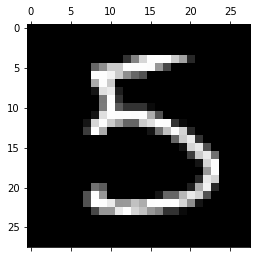

In [18]:
img = x_test[15].reshape(28,28)

import matplotlib as plt
%matplotlib inline

plt.pyplot.matshow(img, cmap=plt.pyplot.get_cmap('gray'))
plt.pyplot.show()